### 1 : Importing Libraries

In [1]:
# ignore the warnings in the output
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import libraries and packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import mlflow
from pycaret.classification import *

 ### 2 Reading Data

In [3]:
%%time
##Copy the cleaned data obtained from the data_cleaning notebook into the Data folder before proceeding
dataset = pd.read_csv('Data/cleaned_data.csv')

CPU times: user 302 ms, sys: 100 ms, total: 402 ms
Wall time: 400 ms


In [4]:
dataset.head()

,created_date,city_tier,first_platform_c,first_utm_medium_c,first_utm_source_c,total_leads_droppped,referred_lead,app_complete_flag,assistance_interaction,career_interaction,payment_interaction,social_interaction,syllabus_interaction
0,2021-07-01 00:08:15,1.0,Level0,Level11,Level2,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
1,2021-07-01 00:16:43,2.0,Level3,Level0,others,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
2,2021-07-01 00:22:20,1.0,Level3,Level0,Level0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
3,2021-07-01 00:23:13,1.0,Level1,Level3,others,2.0,0.0,0,0.0,0.0,0.0,0.0,0.0
4,2021-07-01 00:28:38,1.0,Level3,Level0,Level0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0


In [5]:
# drop the data column as it is not needed for training
dataset = dataset.drop(['created_date'], axis=1)

In [6]:
dataset.head()

,city_tier,first_platform_c,first_utm_medium_c,first_utm_source_c,total_leads_droppped,referred_lead,app_complete_flag,assistance_interaction,career_interaction,payment_interaction,social_interaction,syllabus_interaction
0,1.0,Level0,Level11,Level2,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
1,2.0,Level3,Level0,others,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
2,1.0,Level3,Level0,Level0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
3,1.0,Level1,Level3,others,2.0,0.0,0,0.0,0.0,0.0,0.0,0.0
4,1.0,Level3,Level0,Level0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0


### 3 Setting up Environment: 

In [7]:
# create a connection and setup a SQLite database with the name "lead_scoring_model_experimentation.db" in 
# 'Assignment/02_training_pipeline/notebook/' location

import sqlite3 
from sqlite3 import Error

def create_sqlite_connection(db_path, db_file):
    ''' create a db connection to a SQLite databse'''
    conn = None
    # opening the connection for creating the sqlite db
    try:
        conn = sqlite3.connect(db_path+db_file)
        print(sqlite3.version)
        
    #return an error if the connection is not established 
    except Error as e:
        print(e)
    #closing the connecton once the database is created
    finally:
        if conn:
            conn.close()

In [8]:
db_path = '/home/Assignment/02_training_pipeline/notebooks/'
db_file = "lead_scoring_model_experimentation.db"

create_sqlite_connection(db_path, db_file)

2.6.0


In [ ]:
# run the following commond on a terminal
#mlflow server --backend-store-uri='sqlite:///Assignment/02_training_pipeline/notebooks/lead_scoring_model_experimentation.db' --default-artifact-root='/home/mlruns/' --port=6007 --host=0.0.0.0

In [9]:
# create a mlflow tracking uri at "http://0.0.0.0:6007"
## mlflow server cannot be run on port 6007 instead 6006
mlflow.set_tracking_uri('http://0.0.0.0:6007')

In [ ]:
# setup pycaret 
Baseline_model_exp01 = setup(data=dataset, target='app_complete_flag',
                             session_id=42, fix_imbalance=False, 
                             ignore_features=None, date_features=None,
                             n_jobs=-1, use_gpu=True,
                             log_experiment=True, experiment_name='Baseline_model_exp01',
                             log_plots=True, log_data=True, 
                             silent=True, verbose=True,
                             log_profile=False
                            )

IntProgress(value=0, description='Processing: ', max=3)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,19:25:35
Status,. . . . . . . . . . . . . . . . . .,Preprocessing Data


### 4 : Model Experimentation with pycaret

In [22]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']
best_model = compare_models(exclude= ['gbc','knn','qda', 'dummy', 'svm', 'ada'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7388,0.8211,0.8329,0.7027,0.7623,0.4770,0.4856,1.8080
rf,Random Forest Classifier,0.7372,0.8188,0.8245,0.7037,0.7593,0.4738,0.4811,13.3400
et,Extra Trees Classifier,0.7367,0.8180,0.8214,0.7043,0.7583,0.4730,0.4798,16.5850
dt,Decision Tree Classifier,0.7364,0.8170,0.8208,0.7041,0.7580,0.4723,0.4791,0.5780
lr,Logistic Regression,0.7099,0.7836,0.8221,0.6733,0.7403,0.4192,0.4299,4.4010
lda,Linear Discriminant Analysis,0.7005,0.7732,0.7962,0.6701,0.7278,0.4003,0.4077,1.2950
ridge,Ridge Classifier,0.7004,0.0000,0.7960,0.6702,0.7277,0.4002,0.4076,0.1590
nb,Naive Bayes,0.6625,0.7334,0.8931,0.6128,0.7268,0.3232,0.3646,0.1400


In [23]:
# create a model which gives the highest accuracy

lgbm = create_model('lightgbm', fold=10)

In [24]:
lgbm

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

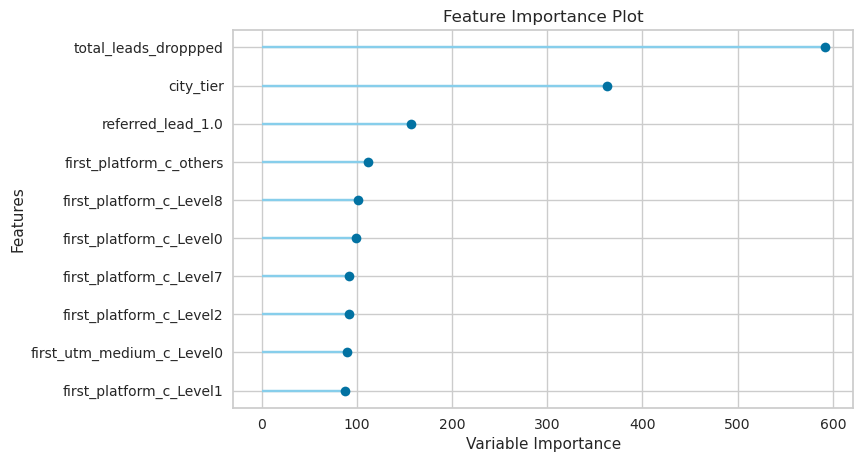

In [29]:
# create feature importance plot
plot_model(lgbm, plot= 'feature')

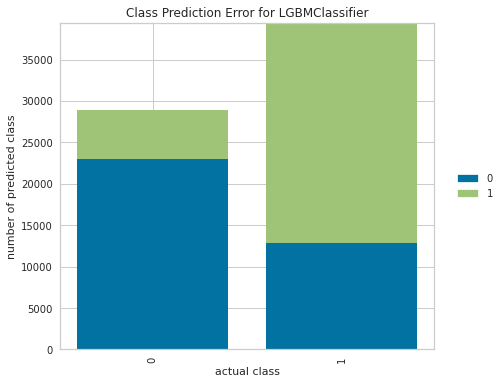

In [30]:
plot_model(lgbm, plot = 'error')

### 5 : Model Experimentation after dropping features

From the above feature tests we can claerly see that some of the features are not significant. We will now drop all the insignificant features and select only the significant ones.
The list of the significant features is 
['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c'].
So now you will train your model with onlly these features.

Also note that in our previous experiments we saw that tree based models are our top performers. In case of tree based models we do not require transformationss normalization, scaling etc. So make sure that you use setup pycaret in the proper way. i.e, make sure that you use normalize = False and transformation = False.

In [33]:
# 
# ['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']
#
# Train the model using the features listed above. Since we are using tree models we do not require any transformaions 
# such as normalization, scaling etc.So make sure that you use setup pycaret in the proper way. i.e, make sure that you use 
# normalize = False and transformation = False.

include_cols = ['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']
df_new = dataset[include_cols]
print(df_new.shape)
df_new.head()


Baseline_model_exp01 = setup(data=df_new, target='app_complete_flag',
                             session_id=42, fix_imbalance=False, 
                             transformation=False, normalize=False,
                             ignore_features=None, date_features=None,
                             n_jobs=-1, use_gpu=True,
                             log_experiment=True, experiment_name='Baseline_model_exp02',
                             log_plots=True, log_data=True, 
                             silent=True, verbose=True,
                             log_profile=False
                            )

,Description,Value
0,session_id,42
1,Target,app_complete_flag
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(238964, 7)"
5,Missing Values,False
6,Numeric Features,2
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


In [34]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']. 
best_model = compare_models(exclude= ['gbc','knn','qda', 'dummy', 'svm', 'ada'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7386,0.8211,0.8337,0.7022,0.7623,0.4766,0.4853,1.7790
rf,Random Forest Classifier,0.7372,0.8187,0.8246,0.7037,0.7593,0.4739,0.4812,12.7620
et,Extra Trees Classifier,0.7367,0.8179,0.8213,0.7042,0.7582,0.4728,0.4796,15.7920
dt,Decision Tree Classifier,0.7364,0.8170,0.8207,0.7040,0.7579,0.4722,0.4790,0.5430
lr,Logistic Regression,0.7099,0.7835,0.8222,0.6732,0.7403,0.4191,0.4299,2.2980
ridge,Ridge Classifier,0.7002,0.0000,0.7957,0.6699,0.7274,0.3997,0.4070,0.1320
lda,Linear Discriminant Analysis,0.7002,0.7726,0.7957,0.6699,0.7274,0.3997,0.4070,1.0880
nb,Naive Bayes,0.6691,0.7336,0.8573,0.6246,0.7227,0.3368,0.3634,0.1330


In [35]:
# You should get lightgbm as the best performing model. So now we will train a lightGBM model manually using pycaret
lgbm = create_model('lightgbm', fold=10) 

In [37]:
# Tune the hyper parameters of the lightgbm model using optuna on 10 folds and optimise AUC as that was our system metric, 
# hence we will optimise AUC

tuned_lgbm, tuner_0 = tune_model(lgbm,
                                 search_library='optuna',
                                 search_algorithm='random',
                                 fold=10,
                                 optimize='AUC',
                                 choose_better=True,
                                 return_tuner=True)

In [40]:
# Print the final models configuration so that we can use it in the model retraining pipeline 
print(tuner_0)

OptunaSearchCV(callbacks=None,
               cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
               enable_pruning=False, error_score='raise',
               estimator=Pipeline(memory=None,
                                  steps=[('empty_step', 'passthrough'),
                                         ('actual_estimator',
                                          LGBMClassifier(boosting_type='gbdt',
                                                         class_weight=None,
                                                         colsample_bytree=1.0,
                                                         importance_type='split',
                                                         learning_rate=0.1,
                                                         max_depth=-...
                                    'actual_estimator__reg_alpha': FloatDistribution(high=10.0, log=True, low=1e-10, step=None),
                                    'actual_estimator__

In [41]:
print(tuned_lgbm)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


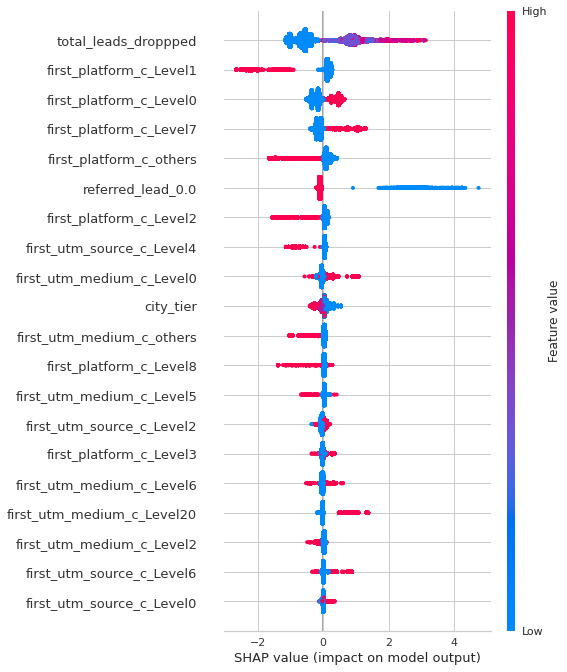

In [43]:
interpret_model(tuned_lgbm)

In [45]:
# index of observation in test data
interpret_model(tuned_lgbm, plot='reason', observation= 0)